In [8]:
import random

table_imgs_dir_bash_path = 'E:/05-OrderProjects/2024/12-3-no/table_imgs/'

with open(table_imgs_dir_bash_path+'gt.txt',encoding='utf-8') as f:
    lines = f.readlines()
random.shuffle(lines)
train_len = int(len(lines)*0.9)
train_list = lines[:train_len]
val_list = lines[train_len:]

# 保存结果
with open(table_imgs_dir_bash_path+'train.txt','w',encoding='utf-8') as f:
    f.writelines(train_list)
with open(table_imgs_dir_bash_path+'val.txt','w',encoding='utf-8') as f:
    f.writelines(val_list)

查看数据集

In [9]:
import cv2
import os, json
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [10]:
def parse_line(data_dir, line):
    data_line = line.strip("\n")
    info = json.loads(data_line)
    file_name = info['filename']
    cells = info['html']['cells'].copy()
    structure = info['html']['structure']['tokens'].copy()

    img_path = os.path.join(data_dir, file_name)
    if not os.path.exists(img_path):
        print(img_path)
        return None
    data = {
        'img_path': img_path,
        'cells': cells,
        'structure': structure,
        'file_name': file_name
    }
    return data

def draw_bbox(img_path, points, color=(255, 0, 0), thickness=2):
    if isinstance(img_path, str):
        img_path = cv2.imread(img_path)
    img_path = img_path.copy()
    for point in points:
        cv2.polylines(img_path, [point.astype(int)], True, color, thickness)
    return img_path


def skip_char(text, sp_char_list):
    """
    skip empty cell
    @param text: text in cell
    @param sp_char_list: style char and special code
    @return:
    """
    for sp_char in sp_char_list:
        text = text.replace(sp_char, '')
    return text

def rebuild_html(data):
    html_code = data['structure']
    cells = data['cells']
    to_insert = [i for i, tag in enumerate(html_code) if tag in ('<td>', '>')]

    for i, cell in zip(to_insert[::-1], cells[::-1]):
        if cell['tokens']:
            text = ''.join(cell['tokens'])
            # skip empty text
            sp_char_list = ['<b>', '</b>', '\u2028', ' ', '<i>', '</i>']
            text_remove_style = skip_char(text, sp_char_list)
            if len(text_remove_style) == 0:
                continue
            html_code.insert(i + 1, text)

    html_code = ''.join(html_code)
    return html_code

In [11]:
save_dir = table_imgs_dir_bash_path+ 'vis'
os.makedirs(save_dir, exist_ok=True)
image_dir = table_imgs_dir_bash_path
html_str = '<table border="1">'

In [12]:
train_list[1][:20]

'{"filename": "05.jpg'

C:\Users\001\AppData\Local\Temp\ipykernel_4832\3132948624.py:15: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


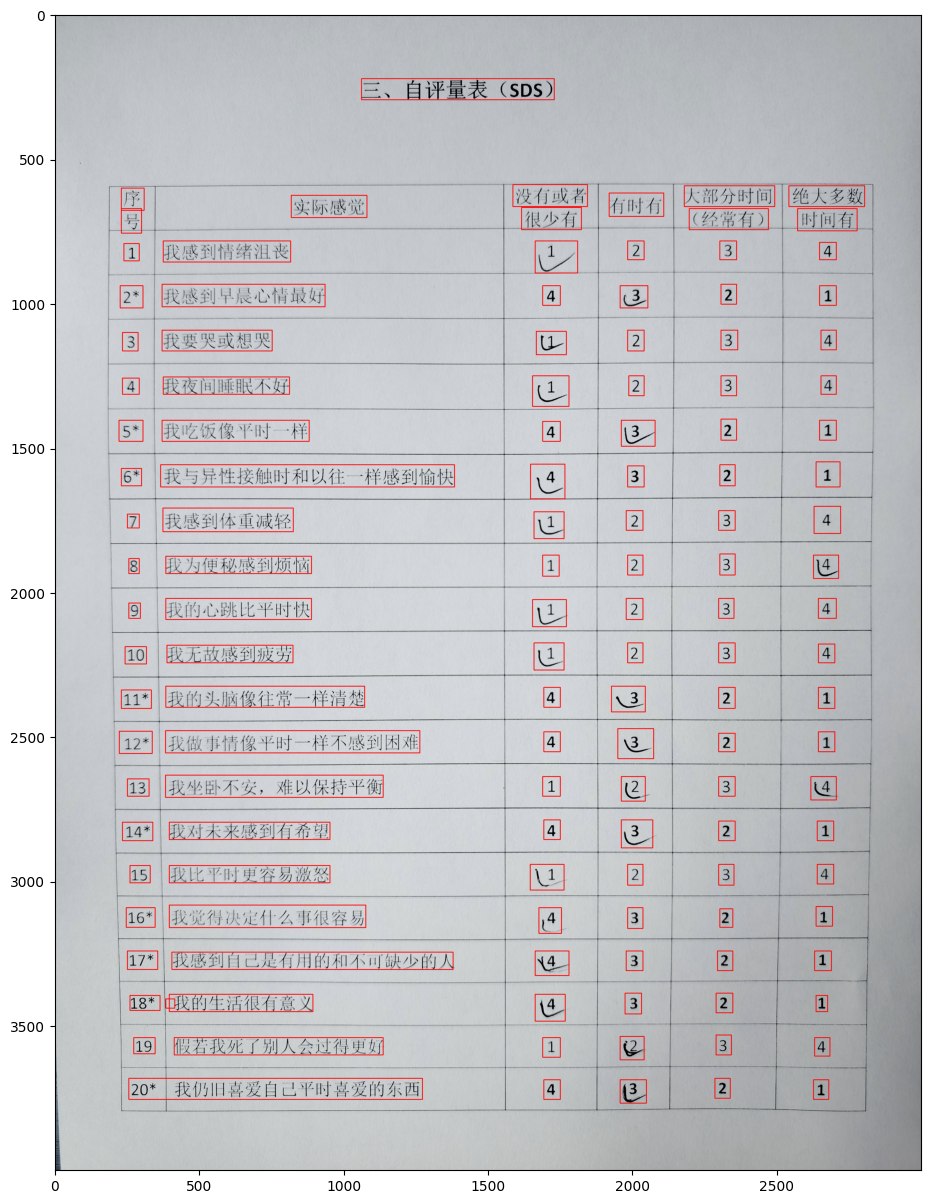

In [13]:
data = parse_line(image_dir, train_list[1])

img = cv2.imread(data['img_path'])
img_name = ''.join(os.path.basename(data['file_name']).split('.')[:-1])
img_save_name = os.path.join(save_dir, img_name)
boxes = [np.array(x['bbox']) for x in data['cells']]
show_img = draw_bbox(data['img_path'], boxes)
cv2.imwrite(img_save_name + '_show.jpg', show_img)

html = rebuild_html(data)
html_str += html
html_str += '</table>'

# 显示标注的html字符串
from IPython.core.display import display, HTML
display(HTML(html_str))
# 显示单元格坐标
plt.figure(figsize=(15,15))
plt.imshow(show_img)
plt.show()

In [8]:
working_dir = 'E:/05-OrderProjects/2024/12-3-no/PaddleOCR-2.7.0'
os.chdir(working_dir)

!python3 tools/train.py -c E:/05-OrderProjects/2024/12-3-no/PaddleOCR-2.7.0/configs/table/SLANet_ch_for_table.yml